<a href="https://colab.research.google.com/github/dddddyoung2/Project_FER/blob/main/Facial_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 얼굴 표정 인식 모델

- 목표
  - 얼굴 표정 분류 모델을 만들어서 웹캠 또는 비디오 파일을 통해 실시간으로 표정을 분석할 수 있게 함
  - 사람은 ~같아라고 표현. 딥러닝을 이용하면 감정을 확률로 표현할 수 있어 감정의 순위를 볼 수 있고, 감정을 추측하는 과정을 볼 수 있음
  
- 게임, 교육, 상담 장면에서 활용할 수 있음
- 참고 학술 자료: 교육자에게 도움을 주기 위해? 실시간 강의에서 딥러닝 표정 인식을 활용한 실시간
온라인 강의 이해도 분석

## 1. 데이터셋
- 얼굴 표정 인식 dataset
- 링크:
https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

- 데이터셋 설명
  - Train, validation
  - 7가지의 얼굴 표정
    - angry, disgust, fear, happy, neutral, sad, surprise

- 이 모델의 한계: 
  - deep한 모델을 만들어서 정확도를 높일 수도 있지만, 그렇게 되면 실시간으로 사용하기에 어려움이 있음 -> 정확도와 속도를 trade-off 한다.

## 2. Set- up

In [ ]:
# !pip install --upgrade pip

In [ ]:
# !pip install opencv_python==4.1.1.26
# !pip install keras==2.3.1
# !pip install pandas==0.24.2
# !pip install numpy==1.17.4
# !pip install imutils==0.5.3
# !pip install scikit_learn==0.22.1
# !pip install tensorflow==2.2



---



---



Fastai
- Google Colab 을 사용하면 설치 없이 fastai를 사용할 수 있다.
- Colab 런타임을 "GPU"로 변경하여 빠르게 실행한다.

In [1]:
%reload_ext autoreload
%autoreload 2 #load한 코드가 수정되었을 때, 자옫으로 reload를 진행함(?)
%matplotlib inline

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 8.6 MB/s 
     |████████████████████████████████| 188 kB 68.6 MB/s 
     |████████████████████████████████| 46 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 314 kB/s 
Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Projects'

Mounted at /content/gdrive


In [4]:
from fastbook import *
from fastai.vision import *
from fastai.metrics import error_rate

## 데이터 로드

- face 데이터셋을 저장할 directory를 만든다
  - drectory name: 'Projects/faces/'
- 캐글에서 받은 데이터셋을 알집을 폴더에 올리고 알집을 푼 후, directory를 옮긴다.

In [5]:
path = Path(base_dir+'/faces/')
#path.mkdir(parents=True, exist_ok=True)

In [6]:
path

Path('/content/gdrive/My Drive/Projects/faces')

In [7]:
cd '/content/gdrive/My Drive/Projects/faces'

/content/gdrive/My Drive/Projects/faces


In [ ]:
# 데이터셋 압축 풀기
!unzip -o face-expression-recognition-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating: images/validat

In [8]:
from fastai.vision.data import ImageDataLoaders

np.random.seed(42)
path_data = Path(base_dir+'/faces/images/images')
data = ImageDataLoaders.from_folder(path_data,
                                  train = 'train', 
                                  valid='validation',
                                  item_tfms=RandomResizedCrop(224, min_scale=4), 
                                  batch_tfms=Normalize.from_stats(*imagenet_stats))

In [9]:
data.valid_ds

(#7066) [(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0)),(PILImage mode=RGB size=48x48, TensorCategory(0))...]

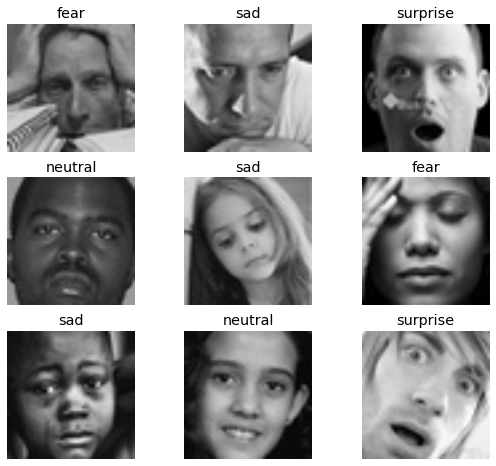

In [10]:
data.show_batch(figsize=(9,8))

## 학습


- CNN learner를 사용해 모델을 학습한다.
- learner는 이미지 데이터와 resnet24를 사용해 모델을 학습한다.
- metrics는 오류율을 나타내도록 한다.

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


- 그리고 데이터셋을 훈련한다.
- 4 eopch 이후 오류 41.8%로 감소했다.

In [13]:
learn.fit_one_cycle(4) # 데이터셋 4번 전달

epoch,train_loss,valid_loss,error_rate,time
0,1.803451,1.414614,0.522219,46:38
1,1.276876,1.188758,0.442966,01:47
2,1.115489,1.117706,0.424568,01:47
3,1.017833,1.103093,0.418483,01:47


In [14]:
learn.save('stage-1')

Path('/content/gdrive/My Drive/Projects/faces/images/images/models/stage-1.pth')

In [15]:
learn.load('stage-1')

- learn unfreeze을 사용하면 전체 모델을 교육하고, 학습률과 학습률에 대한 손실 플롯을 찾을 수 있다.
- 손실의 가장 가파른 곳을 찾아 더 맞추는 데 사용한다.

In [16]:
learn.unfreeze() # 모델 처음부터 다시 학습

- Learning rate에 관한 참고 자료: https://www.bookstack.cn/read/th-fastai-book/spilt.5.0661b9d7375f45ab.md

- `2015년 연구원인 레슬리 스미스는 학습률 측정기라는 기발한 아이디어를 생각해냈다. 그의 아이디어는 아주 아주 작은 학습률로 시작하는 것이었습니다. 너무 작아서 감당할 수 없을 정도로 작은 학습률로 시작하는 것이었죠. 미니배치 1개에 대해 이 값을 사용하고, 이후 손실이 얼마인지 파악한 다음 학습률을 일정 비율(예: 매번 두 배 증가) 높입니다. 그런 다음 미니배치를 다시 수행하여 손실을 추적하고 학습률을 두 배로 높입니다. 손실이 더 심해질 때까지 계속하는 거야 더 낫기는커녕 여기가 우리가 너무 멀리 갔다는 것을 아는 지점이다. 그런 다음 이 시점보다 약간 낮은 학습률을 선택합니다.`


SuggestedLRs(valley=7.585775892948732e-05)

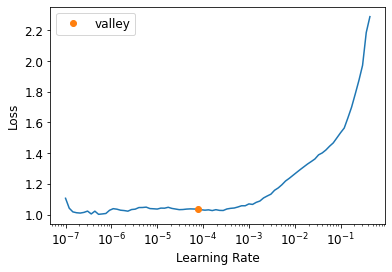

In [17]:
learn.lr_find() # 기본 데이터에 가장 적합한 학습률

- 1e-6(10^-7) 부터 1e-3(10^-4) 까지 loss가 낮다가 그 후부터는 loss가 높아지는 것을 볼 수 있다.
- valley 부분의 Learning Rate '1e-3' 이다.
- 예제 코드를 응용해 손실이 낮은 구간으로 자르고 다시 학습시킨다.
  - 예제 코드: `learn.fit_one_cycle(8, max_lr=slice(1e-4,3e-4))`
  - 응용: `learn.fit_one_cycle(4, max_Ir=slice(1e-4, 3e-4))`
    - 1e-4(0.0001) ~ 3e-4(0.0003)
    - max_Ir 코드 에러로 slice 만 표시한다.

In [24]:
#learn.fit_one_cycle(8, max_lr=slice(1e-5, 3e-5))
learn.fit_one_cycle(4, slice(0.00001, 0.00003))

epoch,train_loss,valid_loss,error_rate,time
0,0.578417,1.043820,0.378857,02:25
1,0.486349,1.067893,0.374469,02:24
2,0.287503,1.144026,0.386499,02:24
3,0.197842,1.153096,0.383244,02:23


- 오류율 38%로 감소, 정확도는 62%라는 결과를 얻었다.

In [25]:
learn.save('stage-2')

Path('/content/gdrive/My Drive/Projects/faces/images/images/models/stage-2.pth')

In [26]:
learn.load('stage-2');

## Results

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

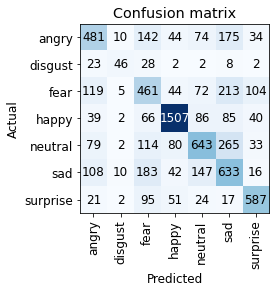

In [28]:
interp.plot_confusion_matrix()

- disgust는 데이터가 적어서 잘 분류되지 않는 것으로 보인다.

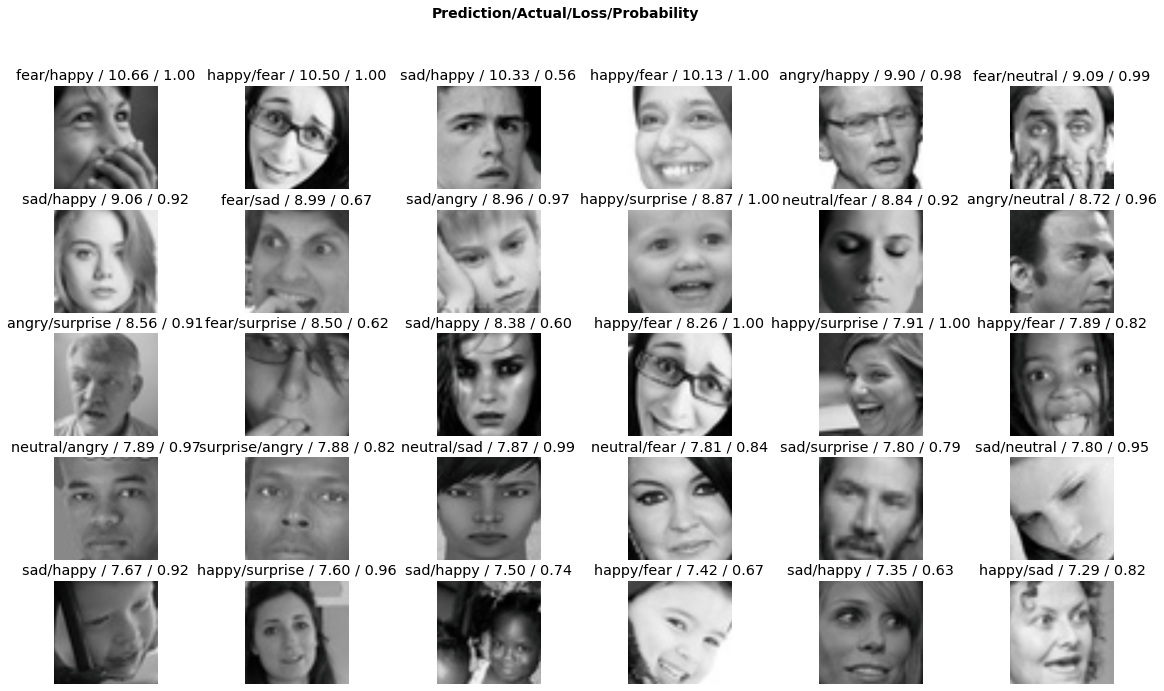

In [29]:
interp.plot_top_losses(30, figsize=(20,11))

- 왼쪽은 모델이 예측한 감정, 오른쪽은 분류된 감정이다.
- 이 모델의 한계: 
  - 학습 결과를 보면, 기존 데이터셋에서 감정이 잘못 표기되어 있는 경우가 다수이다. 데이터 정리가 더 필요할 것으로 보인다.
  - 인공지능의 한계: 억지로 보인 미소가 'happy'의 감정으로 추측될 수 있다.



---



+추가 내용
## 실시간 영상에서 훈련된 모델 사용 시도

In [30]:
from scipy.spatial import distance as dist
import numpy as np
import cv2
from imutils import face_utils
from imutils.video import VideoStream
from fastai.vision import *
import imutils
import argparse
import time
import dlib



---
부록

## 에러 해결

In [ ]:
# case 1: imageDataBunch error, get_transforms error
## ImageDataLoader로 해결

np.random.seed(42)
path_data = Path(base_dir+'/faces/images/images')
data = ImageDataBunch.from_folder(path_data, 
                                  train = 'train', 
                                  valid='validation',
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  num_workers=4).normalize(imagenet_stats)

NameError: ignored